In [308]:
import multiprocessing
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from fractions import Fraction
import time
import sys
from concurrent.futures import ProcessPoolExecutor
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from fractions import Fraction
import time



cores = multiprocessing.cpu_count()

T = 50
dt = 0.001
dyn = {"g":9.8, "m2": 1.0, "l": 1.0, "m1": 1.0}
K = 6
delta0 = 1e-4
x0 = np.array([ np.pi/2,  0 , 0, 0 ])
I1 = np.array([1.0, 0.0, 0.0, 0.0])
I2 = np.array([0.0, 1.0, 0.0, 0.0])
I3 = np.array([0.0, 0.0, 1.0, 0.0])
I4 = np.array([0.0, 0.0, 0.0, 1.0])

def double_pendulum (x0, dyn):
    g = dyn['g']
    l = dyn['l']
    m1 = dyn['m1']
    m2 = dyn['m2']
    #print (x0)
    f = np.array([x0[1],
                  ((-(1.25 + 0.5*np.cos(x0[2]))*(((1.25 + 0.5*np.cos(x0[2]))*(4.9*np.cos(x0[0] + x0[2]) + 14.7*np.cos(x0[0]) - 0.5*(x0[3]**2)*np.sin(x0[2]) - np.sin(x0[2])*x0[1]*x0[3])) / (3.5 + np.cos(x0[2])) - 4.9*np.cos(x0[0] + x0[2]) - 0.5*(x0[1]**2)*np.sin(x0[2]))) / (1.25 + (-((1.25 + 0.5*np.cos(x0[2]))**2)) / (3.5 + np.cos(x0[2]))) + 0.5*(x0[3]**2)*np.sin(x0[2]) + np.sin(x0[2])*x0[1]*x0[3] - 4.9*np.cos(x0[0] + x0[2]) - 14.7*np.cos(x0[0])) / (3.5 + np.cos(x0[2])),
                  x0[3],
                  (((1.25 + 0.5*np.cos(x0[2]))*(4.9*np.cos(x0[0] + x0[2]) + 14.7*np.cos(x0[0]) - 0.5*(x0[3]**2)*np.sin(x0[2]) - np.sin(x0[2])*x0[1]*x0[3])) / (3.5 + np.cos(x0[2])) - 4.9*np.cos(x0[0] + x0[2]) - 0.5*(x0[1]**2)*np.sin(x0[2])) / (1.25 + (-((1.25 + 0.5*np.cos(x0[2]))**2)) / (3.5 + np.cos(x0[2])))
                 ], dtype=np.float32)


#     g = np.array([0,
#                   (-1.25 - 0.5*np.cos(x0[2])) / ((1.25 + (-((1.25 + 0.5*np.cos(x0[2]))**2)) / (3.5 + np.cos(x0[2])))*(3.5 + np.cos(x0[2]))),
#                   0,
#                   1 / (1.25 + (-((1.25 + 0.5*np.cos(x0[2]))**2)) / (3.5 + np.cos(x0[2])))
#                  ], dtype=np.float32)
#     return f + g*0
    return f


def RungeKutta (dyn, f, dt, x0):
    k1 = f(x0, dyn) #[x,y,z]*0.1 example
    k2 = f(x0+0.5*k1*dt,dyn)
    k3 = f(x0 + 0.5*k2*dt, dyn)
    k4 = f(x0 + k3*dt, dyn)

    x = x0 + ((k1 + 2*k2 + 2*k3 + k4)/6) *dt
    return x


def f_t (dyn, f, dt, x0, T, K, delta0):
    x = np.empty(shape=(len(x0),T))
    xc1 = np.empty(shape=(len(x0),T))
    xc2 = np.empty(shape=(len(x0),T))
    xc3 = np.empty(shape=(len(x0),T))
    xc4 = np.empty(shape=(len(x0),T))
    
    x0c1 = x0 + I1*delta0
    x0c2 = x0 + I2*delta0
    x0c3 = x0 + I3*delta0
    x0c4 = x0 + I4*delta0
    
    le = np.array([0,0,0,0])
    for j in range(0,K):

        xc1[:, 0] = x0c1
        xc2[:, 0] = x0c2
        xc3[:, 0] = x0c3
        xc4[:, 0] = x0c4
        x[:, 0] = x0
        for i in range(1,T):
            x[:, i] = RungeKutta(dyn, f, dt, x[:, i-1])
            xc1[:, i] = RungeKutta(dyn, f, dt, xc1[:, i-1])
            xc2[:, i] = RungeKutta(dyn, f, dt, xc2[:, i-1])
            xc3[:, i] = RungeKutta(dyn, f, dt, xc3[:, i-1])
            xc4[:, i] = RungeKutta(dyn, f, dt, xc4[:, i-1])
        
        delta1x = x[:, -1] - xc1[:, -1]
        delta2x = x[:, -1] - xc2[:, -1]
        delta3x = x[:, -1] - xc3[:, -1]
        delta4x = x[:, -1] - xc4[:, -1]
#         print (delta1x)
        
        v1 = delta1x
        norm1 = np.linalg.norm(delta1x)
        u1 = v1/norm1

        GSC1 = np.dot(delta2x, u1)
        v2 = delta2x - GSC1*u1

        norm2 = np.linalg.norm(v2)
        u2 = v2/norm2

        GSC2 = np.dot(delta3x, u1)
        GSC3 = np.dot(delta3x, u2)
        v3 = delta3x - GSC2*u1 - GSC3*u2
        norm3 = np.linalg.norm(v3)
        u3 = v3/norm3
        
        GSC4 = np.dot(delta4x, u1)
        GSC5 = np.dot(delta4x, u2)
        GSC6 = np.dot(delta4x, u3)
        v4 = delta4x - GSC4*u1 - GSC5*u2 - GSC6*u3
        norm4 = np.linalg.norm(v4)
        u4 = v4/norm4
        
        x0c1 = x[:, -1]  + u1*delta0
        x0c2 = x[:, -1]  + u2*delta0
        x0c3 = x[:, -1]  + u3*delta0
        x0c4 = x[:, -1]  + u4*delta0
        x0 = x[:, -1] 
        
        le = le + np.log(np.array([norm1,norm2,norm3,norm4])/delta0)
#         print(norm1)

    
    return le/(K*T*dt)


In [309]:
le_sample = f_t (dyn, double_pendulum, dt, x0, T, K, delta0)

In [310]:
le_sample

array([ 3.56115804, -1.30562994,  1.02038333, -3.27591141])

In [311]:
def cal_le (x):
    le = f_t (dyn, double_pendulum, 0.01, x, 60, 5, 1e-4)
    return le
# precal_dp_15: 51
# precal_dp_16: 21
l2x = np.linspace(-np.pi ,  np.pi, 11)
l2y = np.linspace(-4 ,  4, 11)
l1x = np.linspace(-np.pi/2, 3*np.pi/2, 11)
l1y = np.linspace(-4 ,  4, 11)
X = np.array(np.meshgrid(l1x,l1y,l2x,l2y))


X_reshaped = X.T.reshape(X.T.shape[0]*X.T.shape[1]*X.T.shape[2]*X.T.shape[3],4)
# X_reshaped = np.append(X_reshaped,np.array([[np.pi/2,0,0,0]]),axis=0)
# new_test_sin = np.array([np.sin(X_reshaped.T[0]),X_reshaped.T[1]])
le_list = []
points = list(X_reshaped)
# print ('I am here')
with ProcessPoolExecutor(max_workers=cores-1) as executor:
    for r in executor.map(cal_le, points, chunksize=10):
        # print (r)
        le_list.append(r)
# print (points[0])
# for i in points:
#   %time le_list.append(cal_le (i))

zs = np.array(le_list)

np.save('precal_doublependulum_cldyn_T30_K10_dt0001_2', zs)
# np.save('/home/015970994/masterchaos/precal_le/Double_pendulum/precal_dp_points_10_300_001_fixedGS', X_reshaped)


# np.save('precal_pendulum_cldyn_T50_K10_dt0001', zs)

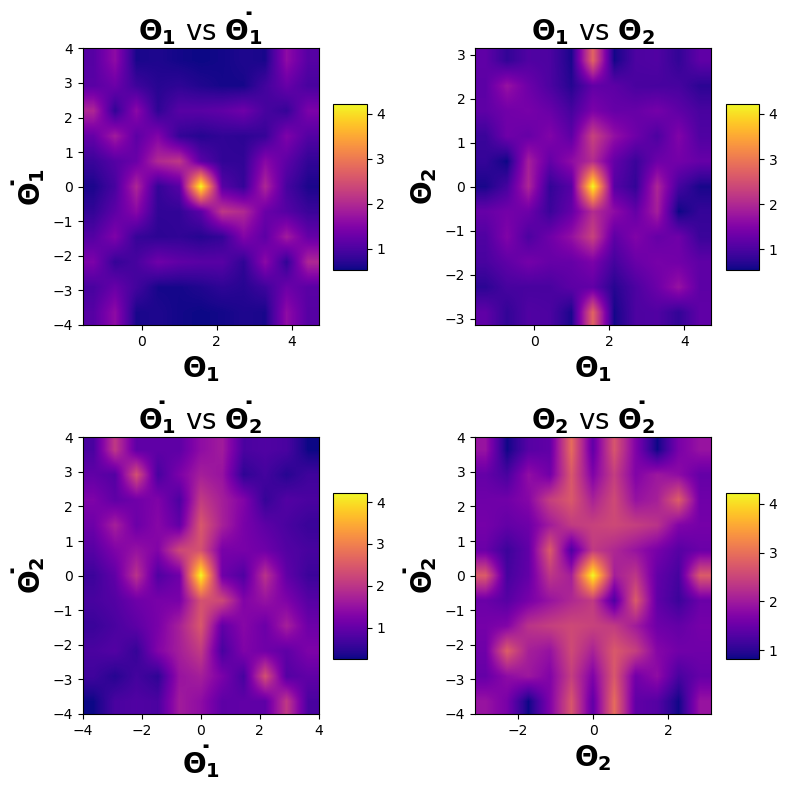

In [316]:
zs1 = np.load('precal_doublependulum_cldyn_T30_K10_dt0001_2.npy')


# l1 = zs[:,0].reshape(21, 21, 21, 21)
# l1[10][10][15][10] = 100

zs_sum_pos = []
for i in zs1:
    zs_sum_pos.append(sum(i[i>0]))
zs = np.array(zs_sum_pos)
# zs = zs1[:,0]
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221)
l1 = zs.reshape(11, 11, 11, 11)[5,5,:,:]
plot1 = ax1.imshow(np.flip(l1,1),extent=[-np.pi/2, 3*np.pi/2,-4,4],cmap='plasma',aspect='auto',interpolation="bilinear")
cbar1 = fig.colorbar(plot1, shrink=0.6, aspect=5)
# ax1.plot(tjt[0],tjt[2],linewidth=3, c='white')
ax1.set_title(r"$\mathbf{\Theta_1}$ vs $\mathbf{\dot{\Theta_1}}$", fontsize=20)
ax1.set_xlabel(r"$\mathbf{\Theta_1}$", fontsize=20)
ax1.set_ylabel(r"$\mathbf{\dot{\Theta_1}}$", fontsize=20)
ax2 = fig.add_subplot(222)
l2 = zs.reshape(11, 11, 11, 11)[5,:,5,:]
plot2 = ax2.imshow(np.flip(l2,1),extent=[-np.pi/2, 3*np.pi/2,-np.pi,np.pi],cmap='plasma',aspect='auto',interpolation="bilinear")
cbar2 = fig.colorbar(plot2, shrink=0.6, aspect=5)
ax2.set_title(r"$\mathbf{\Theta_1}$ vs $\mathbf{\Theta_2}$", fontsize=20)
ax2.set_xlabel(r"$\mathbf{\Theta_1}$", fontsize=20)
ax2.set_ylabel(r"$\mathbf{\Theta_2}$", fontsize=20)
ax3 = fig.add_subplot(223)
l3 = zs.reshape(11, 11, 11, 11)[:,5,5,:]
plot3 = ax3.imshow(np.flip(l3,1),extent=[-4, 4,-4,4],cmap='plasma',aspect='auto',interpolation="bilinear")
cbar3 = fig.colorbar(plot3, shrink=0.6, aspect=5)
ax3.set_title(r"$\mathbf{\dot{\Theta_1}}$ vs $\mathbf{\dot{\Theta_2}}$", fontsize=20)
ax3.set_xlabel(r"$\mathbf{\dot{\Theta_1}}$", fontsize=20)
ax3.set_ylabel(r"$\mathbf{\dot{\Theta_2}}$", fontsize=20)
ax4 = fig.add_subplot(224)
l4 = zs.reshape(11, 11, 11, 11)[:,:,5,5]
plot4 = ax4.imshow(np.flip(l4,1),extent=[-np.pi, np.pi,-4,4],cmap='plasma',aspect='auto',interpolation="bilinear")
cbar4 = fig.colorbar(plot4, shrink=0.6, aspect=5)
# ax4.plot(tjt[1],tjt[3],linewidth=3, c='white')
ax4.set_title(r"$\mathbf{\Theta_2}$ vs $\mathbf{\dot{\Theta_2}}$", fontsize=20)
ax4.set_xlabel(r"$\mathbf{\Theta_2}$", fontsize=20)
ax4.set_ylabel(r"$\mathbf{\dot{\Theta_2}}$", fontsize=20)

# fig.suptitle('Double Pendulum LE landscape 5s max', fontsize=20)
fig.tight_layout()
# fig.savefig('thesis_plots/pendulum-05.png', transparent=True)

In [ ]:
zs